### A Machine learning approach to identify spurious GPS readings



In [18]:
%run "../common.ipynb"

#fileName="http://www.smartconnectedhealth.org/aura/webroot/db.jsp?q=WITH rows AS (SELECT *,ROW_NUMBER() OVER (ORDER BY mobile_id, id DESC) AS rn FROM loc WHERE (record_type <> 'active' OR record_type IS NULL)) SELECT * FROM rows loc1 WHERE (loc1.rn,loc1.mobile_id)  IN ((SELECT loc2.rn, loc2.mobile_id FROM rows loc2 WHERE loc2.is_valid != 1) UNION (SELECT loc2.rn-1, loc2.mobile_id FROM rows loc2 WHERE loc2.is_valid != 1) UNION (SELECT loc2.rn%2B1, loc2.mobile_id FROM rows loc2 WHERE loc2.is_valid != 1) UNION (SELECT loc2.rn-2, loc2.mobile_id FROM rows loc2 WHERE loc2.is_valid != 1) UNION (SELECT loc2.rn%2B2, loc2.mobile_id FROM rows loc2 WHERE loc2.is_valid != 1) UNION (SELECT loc2.rn-3, loc2.mobile_id FROM rows loc2 WHERE loc2.is_valid != 1) UNION (SELECT loc2.rn%2B3, loc2.mobile_id FROM rows loc2 WHERE loc2.is_valid != 1) )&type=html";
fileName="http://www.smartconnectedhealth.org/aura/webroot/db.jsp?q=WITH%20rows%20AS%20%28SELECT%20*,ROW_NUMBER%28%29%20OVER%20%28ORDER%20BY%20mobile_id,%20id%20DESC%29%20AS%20rn%20FROM%20loc%20WHERE%20%28record_type%20%3C%3E%20%27active%27%20OR%20record_type%20IS%20NULL%29%29%20SELECT%20*%20FROM%20rows%20loc1%20WHERE%20id%20%3E%2024600%20AND%20%28record_type%20%3C%3E%20%27active%27%20OR%20%20record_type%20IS%20null%29&type=html";
fileName = fileName.replace(' ', '%20')
dfOriginal = LoadDataSet(fileName, columns=None, checkForDateTime=False);


In [26]:
from datetime import datetime,timedelta
# Prepare dataset
#
# 1. Drop columns we don't need
# 2. Convert column datatypes as needed; to string, datetime, numbers as needed
# 3. Add Calculated Columns
# 4. Filter out rows and reindex the dataframe
# 5. Display the resulting dataframe
# 6. Show some descriptive statistics

#=====
#1. "ProcessedDateId" column is Intentionally misspelled to show it goes undetected if not careful

columns = '''
id, 
stored_at, measured_at, is_valid, api_key, version, record_type, session_num, 
mobile_id, user_id, caller_ip, 
lat, lon, accuracy, speed, bearing, alt, device_temp, device_pressure, device_humidity, device_light, medication, 
weather_time, temperature_min, temperature_max, humidity, no2, pressure, wind, clouds_sky, notes, attr, the_geom, 
location, activity, battery_level, rn"
'''
toDrop= [k.strip() for k in '''id, api_key, version,  session_num, 
mobile_id, 
user_id, 
caller_ip, device_temp, device_pressure, device_humidity, device_light, medication, weather_time, 
temperature_min, temperature_max, humidity, no2, pressure, wind, clouds_sky, notes, attr, 
the_geom,weatherchecked,pef,fev,

'''.split(",")]
dfL = dfOriginal.drop(toDrop, axis=1, errors="ignore")

##1a -> Set the Prediction column
##   -> Set class names if you know it or make it None
predictColumn = "is_valid"
class_names = ["Inalid", "Valid"]

##2. Some wrong dates causing error here - so lets treat this as str
dfL[predictColumn] = dfL[predictColumn].astype(str)    # Treat this columns as string
#dfL[u'ProcessedDateId']   = dfL[u'ProcessedDateId'].astype(str)      # Treat this columns as string (intentionally included)


#Sorted version for mapping
dfL2 = dfL

#DEBUG For printing entire Data Frame
#pd.set_option('display.max_rows', len(dfL['is_valid']))
#print(dfL)
#pd.reset_option('display.max_rows')


##3. Calculated columns
#dfL[u'DBKLag'] = dfL[u'DBKLag']/60                                   # lets divide this by 60 
#dfL[u'DBKLag'] = dfL.DBKLag.apply(abs)                               # Convert to absolute value 




usedvalids = []
usedinvalids = []

stored_at = []
measured_at = []
is_valid = []
record_type = []
lat = []
lon = []
accuracy = []
speed = []
bearing = []
alt = []
location = []
activity = []
battery_level = []
rn = []

secfromprev = []
sectonext = []
distfromprev = []
disttonext = []
spdfromprev = []
spdtonext = []
angle = []

#print(range(dfL['is_valid'].value_counts()['2']))
#print(dfL['is_valid'][dfL['is_valid']=='2'].index[0])
#print(dfL.loc[dfL['is_valid'] == '2', :])
#print(len(dfL))
#print(random.randint(0, len(dfL)-1))


for k in range(dfL['is_valid'].value_counts()['2']):
    #CALCULATE INFO FOR INVALID POINT
    
    invalididx = dfL['is_valid'][dfL['is_valid']=='2'].index[k]
    if invalididx == 0 or invalididx == len(dfL[predictColumn])-1:
        continue    
    elif dfL['rn'][invalididx]-1 == dfL['rn'][invalididx-1] and dfL['rn'][invalididx]+1 == dfL['rn'][invalididx+1] and dfL['is_valid'][invalididx-1] == '1' and dfL['is_valid'][invalididx+1] == '1':
        usedinvalids.append(invalididx)
        stored_at.append(dfL['stored_at'][invalididx])
        measured_at.append(dfL['measured_at'][invalididx])
        is_valid.append(dfL['is_valid'][invalididx])
        record_type.append(dfL['record_type'][invalididx])
        lat.append(dfL['lat'][invalididx])
        lon.append(dfL['lon'][invalididx])
        accuracy.append(dfL['accuracy'][invalididx])
        speed.append(dfL['speed'][invalididx])
        bearing.append(dfL['bearing'][invalididx])
        alt.append(dfL['alt'][invalididx])
        location.append(dfL['location'][invalididx])
        activity.append(dfL['activity'][invalididx])
        battery_level.append(dfL['battery_level'][invalididx])
        rn.append(dfL['rn'][invalididx])
        
        curdatetime = datetime.strptime(dfL['measured_at'][invalididx].split('.')[0],'%Y-%m-%d %H:%M:%S')
        prevdatetime = datetime.strptime(dfL['measured_at'][invalididx+1].split('.')[0],'%Y-%m-%d %H:%M:%S')
        nextdatetime = datetime.strptime(dfL['measured_at'][invalididx-1].split('.')[0],'%Y-%m-%d %H:%M:%S')
        
        #seconds from previous
        secfromprev.append((curdatetime - prevdatetime).seconds)
        
        
        #seconds to next
        sectonext.append((nextdatetime-curdatetime).seconds)
        
        
        curlat = dfL['lat'][invalididx]
        curlon = dfL['lon'][invalididx]
        
        
        nextlat = dfL['lat'][invalididx-1]
        nextlon = dfL['lon'][invalididx-1]
        
        prevlat = dfL['lat'][invalididx+1]
        prevlon = dfL['lon'][invalididx+1]
        
        #miles to next
        disttonext.append(math.sqrt(69.1*(curlat-nextlat)*69.1*(curlat-nextlat)+(69.1*(curlon - nextlon)*cos(nextlat/57.3))*(69.1*(curlon - nextlon)*cos(nextlat/57.3))))
        #print(disttonext[k])
        
        #miles from prev
        distfromprev.append(math.sqrt(69.1*(curlat-prevlat)*69.1*(curlat-prevlat)+(69.1*(curlon - prevlon)*cos(prevlat/57.3))*(69.1*(curlon - prevlon)*cos(prevlat/57.3))))
        #print(distfromprev[k])
        
        
        
        #Speed in MPH to next
        if sectonext[len(sectonext)-1] != 0:
            spdtonext.append(disttonext[len(disttonext)-1]/(sectonext[len(sectonext)-1]/3600))
        else:
            spdtonext.append(None)
        #print(spdtonext[k])
        
        #Speed in MPH from prev
        if secfromprev[len(secfromprev)-1] != 0:
            spdfromprev.append(distfromprev[len(distfromprev)-1]/(secfromprev[len(secfromprev)-1]/3600))
        else:
            spdfromprev.append(None)
        #print(spdfromprev[k])
        
        #Angle in degrees between previous point, next point, and current point
        if distfromprev[len(distfromprev)-1]*disttonext[len(disttonext)-1] != 0:
            distancebetweennextandprev = math.sqrt(69.1*(prevlat-nextlat)*69.1*(prevlat-nextlat)+(69.1*(prevlon - nextlon)*cos(nextlat/57.3))*(69.1*(prevlon - nextlon)*cos(nextlat/57.3)))
            lawofcos = (math.pow(distancebetweennextandprev,2) - math.pow(distfromprev[len(distfromprev)-1],2) - math.pow(disttonext[len(disttonext)-1],2))/(-2*distfromprev[len(distfromprev)-1]*disttonext[len(disttonext)-1])
            if lawofcos < -1:
                lawofcos = -1
            if lawofcos > 1:
                lawofcos = 1
            angle.append((180/math.pi)*math.acos(lawofcos))
        else:
            angle.append(None)
        #print(angle[k])

for k in range(len(usedinvalids)):
    #FIND A RANDOM VALID POINT THAT HAS VALID ON BOTHS SIDES OF IT
    randvalid = random.randint(1, len(dfL)-2)
    while(randvalid in usedvalids or dfL['is_valid'][randvalid] != '1' or (dfL['rn'][randvalid+1] != dfL['rn'][randvalid]+1) or (dfL['rn'][randvalid-1] != dfL['rn'][randvalid]-1) or dfL['is_valid'][randvalid+1] != '1' or dfL['is_valid'][randvalid-1] != '1'):
        randvalid = random.randint(1, len(dfL)-2)
    
    usedvalids.append(randvalid)
    
    #FIND INFO FOR VALID POINT
    stored_at.append(dfL['stored_at'][randvalid])
    measured_at.append(dfL['measured_at'][randvalid])
    is_valid.append(dfL['is_valid'][randvalid])
    record_type.append(dfL['record_type'][randvalid])
    lat.append(dfL['lat'][randvalid])
    lon.append(dfL['lon'][randvalid])
    accuracy.append(dfL['accuracy'][randvalid])
    speed.append(dfL['speed'][randvalid])
    bearing.append(dfL['bearing'][randvalid])
    alt.append(dfL['alt'][randvalid])
    location.append(dfL['location'][randvalid])
    activity.append(dfL['activity'][randvalid])
    battery_level.append(dfL['battery_level'][randvalid])
    rn.append(dfL['rn'][randvalid])
        
    curdatetime = datetime.strptime(dfL['measured_at'][randvalid].split('.')[0],'%Y-%m-%d %H:%M:%S')
    prevdatetime = datetime.strptime(dfL['measured_at'][randvalid+1].split('.')[0],'%Y-%m-%d %H:%M:%S')
    nextdatetime = datetime.strptime(dfL['measured_at'][randvalid-1].split('.')[0],'%Y-%m-%d %H:%M:%S')
        
    #seconds from previous
    secfromprev.append((curdatetime - prevdatetime).seconds)
        
        
    #seconds to next
    sectonext.append((nextdatetime-curdatetime).seconds)
        
        
    curlat = dfL['lat'][randvalid]
    curlon = dfL['lon'][randvalid]
        
        
    nextlat = dfL['lat'][randvalid-1]
    nextlon = dfL['lon'][randvalid-1]
        
    prevlat = dfL['lat'][randvalid+1]
    prevlon = dfL['lon'][randvalid+1]
        
    #miles to next
    disttonext.append(math.sqrt(69.1*(curlat-nextlat)*69.1*(curlat-nextlat)+(69.1*(curlon - nextlon)*cos(nextlat/57.3))*(69.1*(curlon - nextlon)*cos(nextlat/57.3))))
    #print(disttonext[k])
        
    #miles from prev
    distfromprev.append(math.sqrt(69.1*(curlat-prevlat)*69.1*(curlat-prevlat)+(69.1*(curlon - prevlon)*cos(prevlat/57.3))*(69.1*(curlon - prevlon)*cos(prevlat/57.3))))
    #print(distfromprev[k])
        
        
        
    #Speed in MPH to next
    if sectonext[len(sectonext)-1] != 0:
        spdtonext.append(disttonext[len(disttonext)-1]/(sectonext[len(sectonext)-1]/3600))
    else:
        spdtonext.append(None)
    #print(spdtonext[k])
        
    #Speed in MPH from prev
    if secfromprev[len(secfromprev)-1] != 0:
        spdfromprev.append(distfromprev[len(distfromprev)-1]/(secfromprev[len(secfromprev)-1]/3600))
    else:
        spdfromprev.append(None)
    #print(spdfromprev[k])
        
    #Angle in degrees between previous point, next point, and current point
    if distfromprev[len(distfromprev)-1]*disttonext[len(disttonext)-1] != 0:
        distancebetweennextandprev = math.sqrt(69.1*(prevlat-nextlat)*69.1*(prevlat-nextlat)+(69.1*(prevlon - nextlon)*cos(nextlat/57.3))*(69.1*(prevlon - nextlon)*cos(nextlat/57.3)))
        lawofcos = (math.pow(distancebetweennextandprev,2) - math.pow(distfromprev[len(distfromprev)-1],2) - math.pow(disttonext[len(disttonext)-1],2))/(-2*distfromprev[len(distfromprev)-1]*disttonext[len(disttonext)-1])
        if lawofcos < -1:
            lawofcos = -1
        if lawofcos > 1:
            lawofcos = 1
        angle.append((180/math.pi)*math.acos(lawofcos))
    else:
        angle.append(None)
    #print(angle[k])
    
    
  

newdict = {'stored_at': stored_at,
'measured_at': measured_at,
'is_valid': is_valid,
'record_type': record_type,
'lat': lat,
'lon': lon,
'accuracy': accuracy,
'speed': speed,
'bearing': bearing,
'alt': alt,
'location': location,
'activity': activity,
'battery_level': battery_level,
'rn': rn,
'secfromprev': secfromprev,
'sectonext': sectonext,
'distfromprev': distfromprev,
'disttonext': disttonext,
'spdfromprev': spdfromprev,
'spdtonext': spdtonext,
'angle': angle }

dfLnew = pd.DataFrame(newdict)
dfL = dfLnew



#pd.set_option('display.max_rows', len(dfL['is_valid']))
#print(dfLnew)
#pd.reset_option('display.max_rows')

#print(dfL['rn'][dfL['is_valid']=='2'])


        
##4. Filter rows
n1 = dfL.shape[0]
#dfL = dfL[dfL.DBKLag > 1]                                            # Lets take only those that have a value > 0 
#
## Here are other common filtering you may use:
# dfL = dfL[dfL['OEMModel'] == "Surface Pro 4"]
# dfL = dfL[dfL.OSVersionFull.str.contains("th1") | dfL.OSVersionFull.str.contains("th2")]
# dfL = dfL[dfL.is_valid == '2'-1 | dfL.is_valid == '2' | dfL.is_valid == '2'+1]
#print(dfL[dfL.is_valid == '2'-1 | dfL.is_valid == '2' | dfL.is_valid == '2'+1])
#print(dfL.is_valid[1:] == '2' dfL.is_valid == '2' or dfL.is_valid[:1] == '2')
#pd.set_option('display.max_rows', len(dfL['is_valid']))
#print(dfL)
#pd.reset_option('display.max_rows')

n2 = dfL.shape[0]
print ("Filtering: Number of rows Before {} and After {}".format(n1,n2));

#4a. You may reshuffle the rows if needed to make sure they are not in any particular order
dfL = dfL.sample(frac=1).reset_index(drop=True)

#4b. 
# Once you filter, it is a good idea to reindex such that 0th row matches to 0th row in the resulting dataframe
# To see what happens if you didn't to reindex, comment out the following code and notice index 1 and 3 are visibly missing 

dfL = dfL.reset_index(drop=True) 

#5.
displayDFs(dfL, showIcons=True, showStats=True, maxrows = 4) 

# You can see the entire dataframe by using the following
# HTML(dfL.to_html())

Filtering: Number of rows Before 66 and After 66


count,66.000,66,66.000,53.000,0.000,66.000,65.000,66.000,66,66.000,0.000,66.000,66,66,66.000,66.000,66.000,59.000,60.000,66.000,66
unique,-,1,-,-,0.000,-,-,-,2,-,0.000,-,66,6,-,-,-,-,-,-,66
top,-,null,-,-,-,-,-,-,2,-,-,-,2016-04-10 22:11:24.0,gps,-,-,-,-,-,-,2016-03-11 14:25:44.112572
freq,-,66,-,-,-,-,-,-,33,-,-,-,1,42,-,-,-,-,-,-,1
mean,249.317,-,68.409,67.056,-,76.609,0.186,69.781,-,43.234,-,-58.991,-,-,11500.530,542.773,1277.970,17.472,31.722,4.499,-
std,510.200,-,220.281,66.785,-,115.845,0.348,565.241,-,7.144,-,101.856,-,-,5558.635,1718.368,5570.787,25.931,68.566,8.887,-
min,3.000,-,-27.000,0.000,-,0.000,0.000,0.000,-,24.198,-,-122.691,-,-,172.000,0.000,0.000,0.001,0.004,0.000,-
25%,16.750,-,0.000,2.792,-,0.000,0.026,0.031,-,37.556,-,-122.148,-,-,4015.250,13.000,10.250,1.233,1.698,0.000,-
50%,49.500,-,0.000,53.378,-,0.000,0.060,0.102,-,47.621,-,-122.137,-,-,13108.000,56.000,59.000,7.291,7.879,0.000,-
75%,106.064,-,82.000,120.233,-,175.500,0.180,0.233,-,47.644,-,55.383,-,-,16309.250,140.250,180.750,22.612,37.350,2.622,-
max,2805.000,-,1742.000,179.894,-,343.100,2.531,4592.242,-,47.654,-,127.115,-,-,18539.000,9056.000,35467.000,149.370,466.125,30.250,-


### Descriptive Statistics

In [21]:
#Wade can you find a way to plot the points on a map here!

# Given three consecutive readings from a GPS system (p1, p2, p3), is it possible to detect if p2 is invalid?
# or Give a set of points p1 .. pn, detect all invalid readings!

import folium



midlat = mean(dfL2['lat'])
midlon = mean(dfL2['lon'])



dfL2.reset_index(drop=True,inplace=True)

#pd.set_option('display.max_rows', len(dfL2['is_valid']))
#print(dfL2)
#pd.reset_option('display.max_rows')


map1 = folium.Map(location=(47.643, -122.129) , zoom_start=14)

for k in range(len(usedvalids)):
    if dfL2['is_valid'][usedvalids[k]] == '1':
        #Valid Points Blue
        fcolor = '#0000FF'
    else:
        #Invalid Points Red
        fcolor = '#FF0000'
    
    #map1.circle_marker(location=[dfL['lat'][k], dfL['lon'][k]], radius=500, line_color='#000000',fill_color=fcolor)
    folium.CircleMarker([dfL2['lat'][usedvalids[k]], dfL2['lon'][usedvalids[k]]],
                    radius=7,
                    color=fcolor,
                    fill_color=fcolor,
                   ).add_to(map1)
    folium.CircleMarker([dfL2['lat'][usedvalids[k]-1], dfL2['lon'][usedvalids[k]-1]],
                    radius=7,
                    color=fcolor,
                    fill_color=fcolor,
                   ).add_to(map1)
    folium.CircleMarker([dfL2['lat'][usedvalids[k]+1], dfL2['lon'][usedvalids[k]+1]],
                    radius=7,
                    color=fcolor,
                    fill_color=fcolor,
                   ).add_to(map1)
    
    map1.line([[dfL2['lat'][usedvalids[k]],dfL2['lon'][usedvalids[k]]],[dfL2['lat'][usedvalids[k]+1],dfL2['lon'][usedvalids[k]+1]]], line_color='#000000', line_weight=1)
    map1.line([[dfL2['lat'][usedvalids[k]],dfL2['lon'][usedvalids[k]]],[dfL2['lat'][usedvalids[k]-1],dfL2['lon'][usedvalids[k]-1]]], line_color='#000000', line_weight=1)
    
#print(len(usedinvalids))    
for k in range(len(usedinvalids)):
    if dfL2['is_valid'][usedinvalids[k]] == '1':
        #Valid Points Blue
        fcolor = '#0000FF'
    else:
        #Invalid Points Red
        fcolor = '#FF0000'
    
    #map1.circle_marker(location=[dfL['lat'][k], dfL['lon'][k]], radius=500, line_color='#000000',fill_color=fcolor)
    folium.CircleMarker([dfL2['lat'][usedinvalids[k]], dfL2['lon'][usedinvalids[k]]],
                    radius=7,
                    color=fcolor,
                    fill_color=fcolor,
                   ).add_to(map1)
    folium.CircleMarker([dfL2['lat'][usedinvalids[k]-1], dfL2['lon'][usedinvalids[k]-1]],
                    radius=7,
                    color=fcolor,
                    fill_color='#0000FF',
                   ).add_to(map1)
    folium.CircleMarker([dfL2['lat'][usedinvalids[k]+1], dfL2['lon'][usedinvalids[k]+1]],
                    radius=7,
                    color=fcolor,
                    fill_color='#0000FF',
                   ).add_to(map1)
    
    map1.line([[dfL2['lat'][usedinvalids[k]],dfL2['lon'][usedinvalids[k]]],[dfL2['lat'][usedinvalids[k]+1],dfL2['lon'][usedinvalids[k]+1]]], line_color='#000000', line_weight=1)
    map1.line([[dfL2['lat'][usedinvalids[k]-1],dfL2['lon'][usedinvalids[k]-1]],[dfL2['lat'][usedinvalids[k]],dfL2['lon'][usedinvalids[k]]]], line_color='#000000', line_weight=1)  
        
display(map1)  


d:\student data\documents\anaconda\anaconda\lib\site-packages\ipykernel\__main__.py:49: FutureWarning: line is deprecated. Use add_children(PolyLine) instead
d:\student data\documents\anaconda\anaconda\lib\site-packages\ipykernel\__main__.py:50: FutureWarning: line is deprecated. Use add_children(PolyLine) instead
d:\student data\documents\anaconda\anaconda\lib\site-packages\ipykernel\__main__.py:78: FutureWarning: line is deprecated. Use add_children(PolyLine) instead
d:\student data\documents\anaconda\anaconda\lib\site-packages\ipykernel\__main__.py:79: FutureWarning: line is deprecated. Use add_children(PolyLine) instead


Dropping in prepareDF -  Index(['measured_at', 'stored_at'], dtype='object')


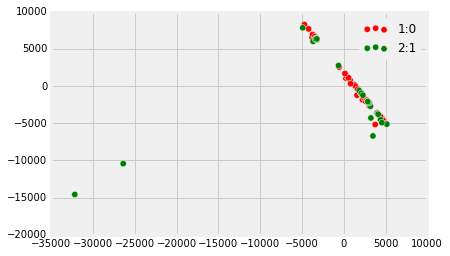

In [22]:
dfPCA=PCAPlot(dfL, predictColumn)

## Predictions

In [23]:
# Lets convert the columns to numeric 
# Please see Prepare in Features.py 

df =  prepareDF(dfL, makeCopy=True)

# Review the resulting final data set;
#df = df.sample(frac=1).reset_index(drop=True)
display(dfL.head(), "==>" ,df.head() )

Dropping in prepareDF -  Index(['measured_at', 'stored_at'], dtype='object')


,accuracy,activity,alt,angle,battery_level,bearing,distfromprev,disttonext,is_valid,lat,location,lon,measured_at,record_type,rn,secfromprev,sectonext,spdfromprev,spdtonext,speed,stored_at
0,16.000,null,60.000,152.858,None,85.000,0.161,0.684,1,47.642,None,-122.136,2016-04-13 19:35:26.0,passive,14230,66,108,8.755,22.792,4.500,2016-04-14 01:39:43.553174
1,400.000,null,0.000,15.843,None,0.000,0.118,0.130,2,47.653,None,-122.144,2016-03-30 00:07:46.0,gps,16395,65,62,6.532,7.526,0.000,2016-03-30 00:23:28.110286
2,50.000,null,0.000,120.233,None,0.000,0.131,0.052,2,47.624,None,-122.157,2016-04-10 22:11:24.0,passive,14712,61,11,7.751,17.180,0.000,2016-04-10 22:43:40.857604
3,1899.999,null,0.000,16.631,None,0.000,1.092,1.735,1,24.199,None,55.634,2016-04-30 09:44:19.0,gps,1544,61,78,64.435,80.099,0.000,2016-04-30 11:49:34.062352
4,46.787,null,0.000,23.315,None,0.000,0.002,0.025,2,47.645,None,-122.137,2016-03-16 00:48:15.0,gps,17787,9056,1975,0.001,0.045,0.000,2016-03-16 01:15:16.379214


'==>'

,accuracy,activity,alt,angle,battery_level,bearing,distfromprev,disttonext,is_valid,lat,location,lon,record_type,rn,secfromprev,sectonext,spdfromprev,spdtonext,speed
0,16.000,0,60.000,152.858,0,85.000,0.161,0.684,0,47.642,0,-122.136,5,14230,66,108,8.755,22.792,4.500
1,400.000,0,0.000,15.843,0,0.000,0.118,0.130,1,47.653,0,-122.144,3,16395,65,62,6.532,7.526,0.000
2,50.000,0,0.000,120.233,0,0.000,0.131,0.052,1,47.624,0,-122.157,5,14712,61,11,7.751,17.180,0.000
3,1899.999,0,0.000,16.631,0,0.000,1.092,1.735,0,24.199,0,55.634,3,1544,61,78,64.435,80.099,0.000
4,46.787,0,0.000,23.315,0,0.000,0.002,0.025,1,47.645,0,-122.137,3,17787,9056,1975,0.001,0.045,0.000


Feature space holds 66 observations and 18 features
Unique target labels: [0 1]
* 0* 1* 2* 3* 4*
   DecisionTree Gini accuracy: 0.621212 
* 0* 1* 2* 3* 4*
   DecisionTree Entr accuracy: 0.757576 
* 0* 1* 2* 3* 4*
                 SVM accuracy: 0.772727 
* 0* 1* 2* 3* 4*
                K-NN accuracy: 0.757576 
* 0* 1* 2* 3* 4*
   Gradient Boosting accuracy: 0.787879 
* 0* 1* 2* 3* 4*
    Logit Regression accuracy: 0.742424 


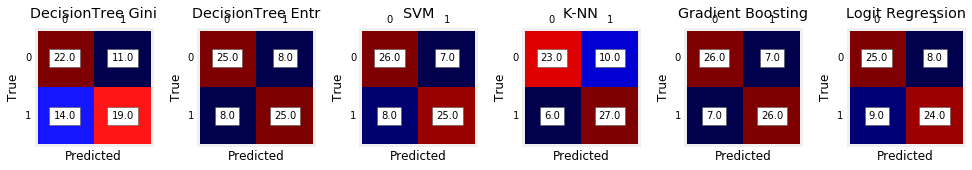

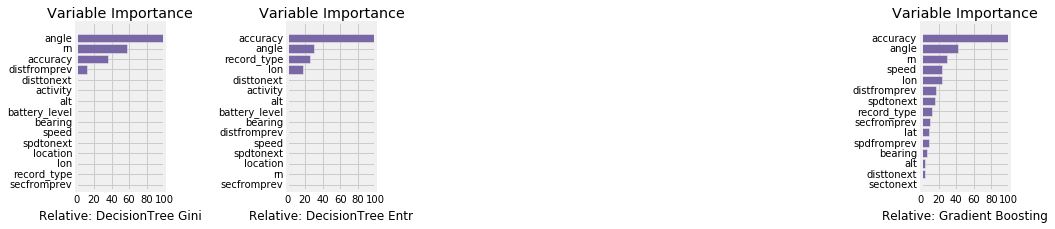

Wall time: 1.32 s


In [24]:
%%time
cls = [# Comment/uncomment out any classfiers according to your need 
       # DO NOT CHANGE
        "DecisionTree Gini" , tree.DecisionTreeClassifier(max_depth=4, criterion="gini"),
        "DecisionTree Entr" , tree.DecisionTreeClassifier(max_depth=4, criterion="entropy"), 
        "SVM"               , sklearn.svm.SVC(), 
        #"Random Forest"     , sklearn.ensemble.RandomForestClassifier(),
        "K-NN"              , sklearn.neighbors.KNeighborsClassifier(),
        "Gradient Boosting" , sklearn.ensemble.RandomForestClassifier(),
        "Logit Regression"  , sklearn.linear_model.LogisticRegression()
];

y = df[predictColumn]
X = df.drop(predictColumn, axis=1)
(X1,y1,ra,cls) = Classify(X,y, True, drawConfusionMatrix=True, classifiers=cls, scale=True)


In [7]:
#get_ipython().reset()
decisionTrees = []

for k in range( int (len(cls)/2)) :
    d = cls[k*2+1];
    if (str(type(d)).find('DecisionTreeClassifier') > 0):
        decisionTrees.append(cls[k*2])
        decisionTrees.append(cls[k*2+1])

#d = DrawDecisionTree(X,y, decisionTrees, class_names);

In [ ]:
#
# Now we need to get the 
# Given three points, distance, angle, time difference, number of time that loc was marked invalid
#

1
2 lat-lon
1
==>
2 speed (1-2); time1 -2 , distance 1-2, angle 1-2-1, # of times 2 is Invalid 

1
1 speed (1-1); time1 -1 , distance 1-1, angle 1-1-1, # of times 1 was read
1
